## Overview
Author: Chenyu Shen (Rainy).  
Last Updates: August 16, 2020.  

This Jupyter notebook is to implement the text readability analysis of 10-K reports and its correlation to company performance by Li (Feng Li, 2008). Specifically, this notebook presents the change of MD&A section's readability, using three different metrics, document's length, fog index, and smog index, of given industry. The result visualization serves as a comparison to Li's paper, to represent the changes of the readabilities of financial reports over time.

In [25]:
# Set up analysis frameworks

# Data mining from edgar
import edgar
from edgar import Company
from bs4 import BeautifulSoup
from edgar import Company, TXTML, XBRL, XBRLElement

# Standard python analysis framework
import pandas as pd
import numpy as np
import re
import unicodedata
from collections import Counter
from collections import defaultdict

# NLP frameworks
from gensim import corpora
import gensim
import textstat
import statistics as stats

# Visualization
import matplotlib
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")


## Preprocess wrds data 

In [53]:
# import data
df = pd.read_csv("data_output/df_na_annual_15-19.csv")

In [54]:
# Data Inspection
print("number of companies in this dataset",len(df['cik'].unique()))

number of companies in this dataset 8437


In [55]:
# Assign naics industry code super class to each row. 
# e.g. 111110 : Soybean Farming, super class = '11', Agriculture, Forestry, Fishing and Hunting
naics = df['naicsh'].to_list()
naics = [str(e)[:4] for e in naics]
df['naics_super'] = naics

In [56]:
# Filter out to keep companies that have all five fiscal years' data

# group by company
grouped = df.groupby('cik').size().reset_index() 
# count records of company to keep those that have only five records
cik_to_keep = grouped[grouped[0] == 6]['cik'].to_list()

# restruct dataframe
df = df[df.cik.isin(cik_to_keep)]
len(df['cik'].unique()) # check number of companies in this dataset

4527

In [61]:
# select industry for analysis. 
# group companies into industries is not required. May proceed with all companies data.
df_industry = df[(df['naics_super'].str.startswith('51'))]

number of companies in Finacne and Insurance (NAICS code starts with '52'): 443


In [62]:
# data inspection of selected industry
df_industry.groupby('conm').mean().sort_values(by = 'Assets - Total', ascending = False).head()

,gvkey,cik,fyear,naicsh,Net Income(Loss),Assets - Total,Stockholders' Equity - Total,ROA,ROE
conm,,,,,,,,,
AT&T INC,9899,732717,2016.5,517244.0,15878.000000,437825.333333,140224.500000,0.035744,0.112665
VERIZON COMMUNICATIONS INC,2136,732712,2016.5,517244.0,17587.500000,255871.166667,34814.333333,0.068322,0.626368
CHINA MOBILE LTD,65662,1117795,2016.5,517244.0,16672.422000,223281.689167,147283.133167,0.074836,0.113574
MICROSOFT CORP,12141,789019,2016.5,511210.0,21346.666667,221465.166667,83217.666667,0.095479,0.251353
COMCAST CORP,3226,1166691,2016.5,515210.0,12123.333333,201410.000000,63644.666667,0.061241,0.188178


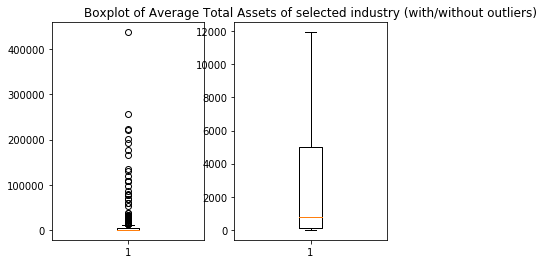

In [63]:
# check companies' size distribution
plt.subplot(1,2,1)
plt.boxplot(x = df_industry.groupby('conm').mean()['Assets - Total'])

plt.subplot(1,2,2)
plt.boxplot(x = df_industry.groupby('conm').mean()['Assets - Total'], showfliers = False)

plt.title("Boxplot of Average Total Assets of selected industry (with/without outliers)")
plt.show()

## Text Mining from Edgar 

Get data from Edgar, based on the companies cik and name.

### Data Sampling

In [79]:
# random sampling by company in selected industry, 
# This step is not required. This is just to save time for a faster data mining process while pertain the analysis quality. 
conm_sample = np.random.choice(df_industry.conm, int(len(df_industry.cik.unique())*.25))
df_sample = df_industry[(df_industry.conm.isin(conm_sample))]


In [80]:
# check sample result
df_sample.groupby('conm').mean().sort_values(by = 'Assets - Total', ascending = False).head()


,gvkey,cik,fyear,naicsh,Net Income(Loss),Assets - Total,Stockholders' Equity - Total,ROA,ROE
conm,,,,,,,,,
MICROSOFT CORP,12141,789019,2016.5,511210.0,21346.666667,221465.166667,83217.666667,0.095479,0.251353
ORANGE,220940,1038143,2016.5,517177.0,2499.660667,108316.615833,34847.043833,0.023184,0.072286
CHINA TELECOM CORP LTD,254338,1191255,2016.5,517177.0,2905.032000,96777.630333,48251.913667,0.030043,0.060234
CHINA UNICOM (HONG KONG) LTD,137066,1113866,2016.5,517244.0,1175.690500,86297.197167,40576.350500,0.013775,0.029217
T-MOBILE US INC,17874,1283699,2016.5,517244.0,2222.000000,69155.333333,21087.000000,0.030382,0.096413


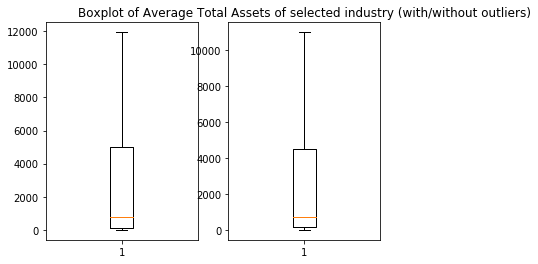

In [81]:
# check sample company's size distribution
plt.subplot(1,2,1)
plt.boxplot(x = df_industry.groupby('conm').mean()['Assets - Total'],showfliers = False)

plt.subplot(1,2,2)
plt.boxplot(x = df_sample.groupby('conm').mean()['Assets - Total'], showfliers = False)

plt.title("Boxplot of Average Total Assets of selected industry (with/without outliers)")
plt.show()

### Text Mining from Edgar 
Text mining from Edgar to analyze 10-K readability over the years.

In [37]:
%%time
"""
This cell is a testing cell to estimate text mining time by single company, on your computer.
"""
# company_docs = []
# from edgar import Company, XBRL, XBRLElement

# company = Company("MASTERCARD INC", "1141391")
# results = company.get_document_type_from_10K("10-K",no_of_documents = 6)

# for d in results:
#     company_docs.append(str(d.text_content()))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [82]:
# Prepare a dictionary of comapny's cik code to name

# list of cik of which 10-K documents needed
cik_lst = df_sample['cik'].to_list()
cik_lst = [str(int(w)) for w in cik_lst]

# list of company names of which 10-K documents needed
conm_lst = df_sample['conm'].to_list()

# populate selected company's code and name look up dictionary: company_codes {cik : company name}
company_codes = dict(zip(cik_lst,conm_lst))

# Prepare a document dictionary to store 10-k documents of each company:  company_docs {cik : [10-k text]}
company_docs = {k : [] for k in cik_lst}


100

In [84]:
%%time
# Text Mining

no_doc = 6 # set the number of most recent documents for your research purpuse. 
#EX.: current date = 2020/07, no_doc = 2, gets documents in 2019 and 2018

for cik, conm in company_codes.items():
    company = Company(conm, cik)
    results = company.get_document_type_from_10K("10-K", no_of_documents = no_doc)

    for d in results:
        text = d.text_content()
        company_docs[cik].append(str(text))

CPU times: user 1min 36s, sys: 5.67 s, total: 1min 42s
Wall time: 7min 55s


### Store/read Data Result to/from Cache

In [230]:
# store/read data to pickle file to cache data.
import pickle

# pickle.dump(company_docs, open( "10k_6years.p", "wb" ) )
# company_docs = pickle.load( open( "10k_6years.p", "rb" ) )

### Text Preprocessing

In [232]:
# remove company with no 10-k records from Edgar
company_docs = {k:v for k,v in company_docs.items() if len(v) >= 6}

In [233]:
len(company_docs)

72

In [306]:
%%time
# Text preprocessing and extracting MD&A section

# prepare a dictionary of company with their list of documents for text analysis: sample_lst {cik, [text]}
sample_lst = {k:[] for k in company_docs.keys()}

for k,v in company_docs.items():
    for i in range(len(v)):
        text = v[i]
        # normalize text
        text = text.lower()
        text = unicodedata.normalize("NFKD", text)
        # remove tab, linefeed
        text = re.sub('\\n|\\t',' ', text)
        # remove duplicate whitespaces
        text = re.sub('\s+',' ',text)
        # ignore amendment 10K/A 
        if len(re.findall('form 10-k/a',text)) == 0:
            # Extract MD&A from the text
            md_a_text = re.findall("item 7\.(.*)item 8\.", text)
            if len(md_a_text) > 0:
                md_a_text = md_a_text[0]
                sample_lst[k].append(md_a_text)

CPU times: user 12.7 s, sys: 546 ms, total: 13.2 s
Wall time: 13.3 s


In [237]:
# # check result for those companies that are not included in the list after preprocessing
# code_lst = []
# for k,doc in sample_lst.items():
#     for d in doc:
#         if type(d) != str:
#             code_lst.append(k)

# # Remove multiple keys from dictionary 
# sample_dct = dict([(key, val) for key, val in 
#            sample_lst.items() if key not in code_lst]) 


In [310]:
# # Debug: code for one company
# text = company_docs['716133'][7]
# # normalize text
# text = text.lower()
# text = unicodedata.normalize("NFKD", text)
# # remove tab, linefeed
# text = re.sub('\\n|\\t',' ', text)
# # remove duplicate whitespaces
# text = re.sub('\s+',' ',text)
# # ignore amendment 10K/A 
# if len(re.findall('form 10-k/a',text)) == 0:
#     # Extract Part 1 item 1 - "Business" from the text
#     md_a_text = re.findall("item 7\.(.*)item 8\.", text)[0]

In [17]:
# # Debug
# with open('sample_text.txt','w') as output:
#     output.write(text)
#     output.close()

## Text Analysis 

In [311]:
# Calculate the readability stats of selected text sections from previous cells.

year_dct = defaultdict(list)

for k,docs in sample_lst.items():
    for i in range(len(docs)):
        # check if text exist
        if type(docs[i]) == str:
            text = docs[i]
            # capitalize first letter of each sentence 
            text = '. '.join(list(map(lambda x: x.strip().capitalize(), text.split('.'))))
            # calculate readability stats
            fog = textstat.gunning_fog(text)
            smog = textstat.smog_index(text)
            length = np.log(len(text.split()))
            year_dct[i].append((fog,smog,length))

In [313]:
# Add data to lists
stats_years = []

for i in range(6):
    fog_years = []
    smog_years = []
    length_years = []
    
    data = year_dct.get(i)
    for j in range(len(data)):
        fog_years.append(data[j][0])
        smog_years.append(data[j][1])
        length_years.append(data[j][2])
        
    stats_years.append((stats.median(fog_years), stats.median(smog_years), stats.median(length_years)))

In [314]:
stats_years

[(13.955, 18.0, 10.339771599499802),
 (13.97, 17.8, 10.334375619864776),
 (14.0, 17.7, 10.310651217279874),
 (13.93, 17.7, 10.24721909083893),
 (14.0, 17.7, 10.244022951891711),
 (13.815000000000001, 17.6, 10.242363721656627)]

## Visualization 

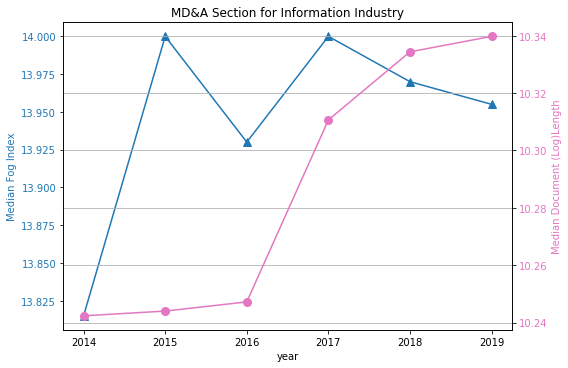

In [324]:
import matplotlib.ticker as ticker

# create data
doc_length = [stats_years[i][2] for i in range(len(stats_years))][::-1]
smog_years = [stats_years[i][1] for i in range(len(stats_years))][::-1]
fog_years = [stats_years[i][0] for i in range(len(stats_years))][::-1]

t = np.array([2014,2015,2016,2017,2018,2019], dtype=np.double)
data2 = doc_length
data1 = fog_years

fig, ax1 = plt.subplots(figsize = (8,5))

# Be sure to only pick integer tick locations.
for axis in [ax1.xaxis, ax1.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

color = 'tab:blue'
ax1.set_xlabel('year')
ax1.set_ylabel('Median Fog Index', color=color)
ax1.plot(t, data1, marker = '^', markersize = 8,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:pink'
ax2.set_ylabel('Median Document (Log)Length', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2,  marker = 'o', markersize = 8, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("MD&A Section for Information Industry")
plt.grid()
plt.show()

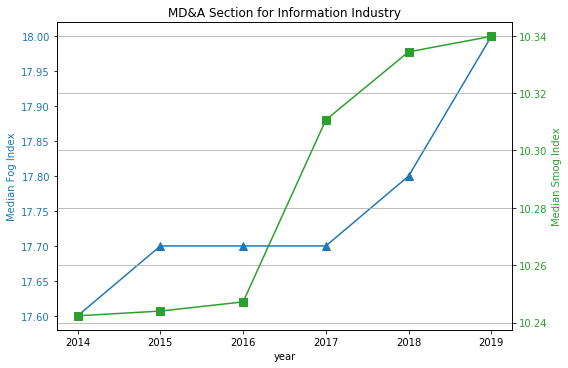

In [325]:
import matplotlib.ticker as ticker

# create data
doc_length = [stats_years[i][2] for i in range(len(stats_years))][::-1]
smog_years = [stats_years[i][1] for i in range(len(stats_years))][::-1]
fog_years = [stats_years[i][0] for i in range(len(stats_years))][::-1]

t = np.array([2014,2015,2016,2017,2018,2019], dtype=np.double)
data2 = doc_length
data1 = smog_years

fig, ax1 = plt.subplots(figsize = (8,5))

# Be sure to only pick integer tick locations.
for axis in [ax1.xaxis, ax1.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

color = 'tab:blue'
ax1.set_xlabel('year')
ax1.set_ylabel('Median Fog Index', color=color)
ax1.plot(t, data1, marker = '^', markersize = 8,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Median Smog Index', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2,  marker = 's', markersize = 8, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("MD&A Section for Information Industry")
plt.grid()
plt.show()

## Reference:
1) *Annual report readability, current earnings, and earnings persistence*, Feng Li, 2008   
2) NAICS Code Documentation: www.naics.com/search/#naics